# Notebook to show feature extraction for bigger spatial areas via client-side block processing
In this example we focus on EU-27 and an area in Slovakia. The prepared tiling grid is generated in the wished output CRS EPSG:3035 (LAEA). The tiling (block processing) is happening on client side.
<br><br>
We will demonstrate how to use the openEO `MultiBackendJobManager` to set-up and track multiple jobs at once using OpenEO. <br> <br>
Key features <br>
Job Tracking: Keep track of jobs their statuses and results across different backends. <br>
Error Handling: Customizable handling of job errors and completed jobs. <br>
Database Support: Persist job metadata using CSV or Parquet files, allowing you to resume tracking after interruptions.<br><br>
The error handling in this example is basic - by restarting the script with the same settings the jobmanager will continue with `not_started` jobs.

In [1]:
import openeo
from openeo.extra.job_management import CsvJobDatabase

from eo_processing.utils import laea20km_id_to_extent, reproj_bbox_to_ll
from eo_processing.utils.helper import init_connection, location_visu, convert_to_list, string_to_dict
from eo_processing.utils.jobmanager import WeedJobManager, create_job_dataframe
from eo_processing.utils.storage import WEED_storage
from eo_processing.utils.geoprocessing import AOI_tiler
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options, generate_storage_options
import eo_processing.resources
import importlib.resources as importlib_resources
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
from shapely import wkt
import time

### specify space and time context

In [50]:
# the time context is given by start and end date
year = 2021
start = f'{year}-01-01'
end = f'{year+1}-01-01'   # the end is always exclusive

# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Slovakia Devin_Lake (wetlands)
AOI = {'east': 4800000, 'south': 2820000, 'west': 4831000, 'north': 2830000, 'crs': 'EPSG:3035'}

### intersect the AOI with the tiling grid to specify the block processing extents

In [51]:
# spatial intersect and retrieve the tile_ID's of the LAEA-20km grid (convert AOI to EPSG:4326)
gdf_aoi = AOI_tiler(reproj_bbox_to_ll(AOI),'EU')

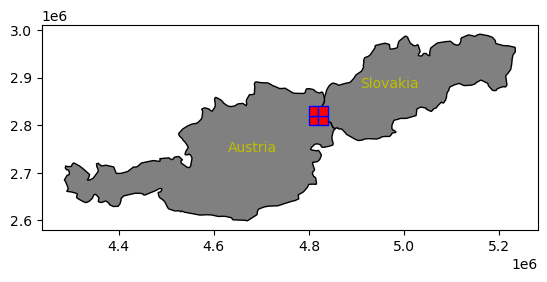

In [46]:
# visualization of the selected- tiles in the tiling grid which needs to be processed to cover the AOI
location_visu(gdf_aoi, zoom=True, region='EU', label=True)

### set the root output folder

In [69]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 18
out_root = os.path.normpath(r'/home/deroob/Private/WEED/tests')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)
#define if S3 workspace is needed
workspace_path = f"tests/Bert/Bert_test_v{str(test_num)}"
storage = WEED_storage(username='deroob',s3_bucket='test')
storage_options = generate_storage_options(workspace_export = True, S3_prefix=workspace_path, local_S3_needed = True, storage=storage)
#storage_options = None


Please enter your password for the Terrascope VAULT:  ········


### integrating the MultiBackendJobManager


#### creating the jobs database
The `MultiBackendJobManager` uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

In [70]:
gdf2 = gdf_aoi.drop('s2_tileid_list', axis=1)

jobs_database = create_job_dataframe(gdf=gdf2,year=2021,file_name_base = 'balbla', processing_type= 'feature', version = f"v{test_num}",
                           storage_options =storage_options, organization_id = 4938)

#jobs_database['s2_tileid_list']= "['31UFS','33UXP']"

In [71]:
jobs_database = jobs_database.iloc[[4]]
jobs_database

,name,tileID,target_epsg,bbox,file_prefix,start_date,end_date,export_workspace,s3_prefix,organization_id,s2_tileid_list,geometry
4,E478N282_2021,E478N282,3035,"{'east': 4800000, 'south': 2820000, 'west': 47...",balbla_feature-cube_year2021_E478N282_2021_v18,2021-01-01,2022-01-01,esa-weed-test-workspace,tests/Bert/Bert_test_v18,4938,<NA>,"MULTIPOLYGON (((16.195 48.32, 16.217 48.499, 1..."


In [8]:
jobs_database2 = jobs_database.iloc[[0]].copy()
jobs_database2['name']='E482N280-E482N282_2021'
jobs_database2['bbox']=jobs_database2['bbox'].str.replace("'north': 2820000","'north': 2840000")
jobs_database2['file_prefix']="balbla_feature-cube_year2021_E482N280-E482N282_2021_v13"
jobs_database2['bbox']

0    {'east': 4840000, 'south': 2800000, 'west': 48...
Name: bbox, dtype: string

#### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In [9]:
from openeo.rest.datacube import THIS 
def start_job(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    tileID = row["tileID"]
    start = row["start_date"]
    end = row["end_date"]
    file_prefix = os.path.normpath(row["file_prefix"])
    processing_extent = string_to_dict(row["bbox"])
    
    # get the openEO bbox dictionary for this tileID of processing block
    #processing_extent = laea20km_id_to_extent(tileID)
    
    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider)
    #job_options['tile_grid']= 'utm-20km'
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')
    
    # add this job option to run it on old openEO version for CDSE server side
    #job_options.update({"image-name": "registry.prod.warsaw.openeo.dataspace.copernicus.eu/prod/openeo-geotrellis-kube:20240905-1881"})
    if not pd.isna(row["organization_id"]):
        job_options.update({'etl_organization_id':row["organization_id"].astype(str)})

    # This processing option add a filter on the S2 input data
    if not pd.isna(row["s2_tileid_list"]):
        s2_tileid_list = convert_to_list(row["s2_tileid_list"])
        processing_options.update({"s2_tileid_list":s2_tileid_list})
        
    # define the progress graph
    data_cube = generate_master_feature_cube(connection,
                                             processing_extent,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)
    saved_cube = data_cube.save_result('GTiff', options={
                               'filename_prefix':file_prefix})#,'separate_asset_per_band':True})

    if not pd.isna(row["s3_prefix"]):
        print("smt wrong")
        data_cube_workspace = saved_cube.export_workspace(
            workspace =  row["export_workspace"],
            merge = row["s3_prefix"]  # this determines the folder structure on the s3 bucket
        )
    else: data_cube_workspace = saved_cube
    
    job = data_cube_workspace.create_job(title=file_prefix, 
                               description=f'generation of full feature data cube of EO data for tile {tileID}', 
                               job_options=job_options)



    return job

#### run the jobs
With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.
<br> <br>
Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [72]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, 'job_tracker.csv'))

In [73]:
# init of MultiBackendJobManager (A viz switch has been added to enable vizualization of status
manager = WeedJobManager(root_dir=os.path.normpath(out_root), storage_options = storage_options , poll_sleep=60, viz=False)

In [74]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse-staging'  # also possible: cdse, terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=1)

Authenticated using refresh token.


In [75]:
# run the jobs stand-alone which blocks further usage of the Notebook up to all jobs are done
#manager.run_jobs(df=jobs_database, start_job=start_job, job_db=job_tracker)

In [76]:
##### better option in a Notebook is to use an extra thread to run the jobs and keep the notebook active
# for that we have to convert our jobs_database into a JobDatabaseInterface which is saved in the job_tracker location
# Note: we make sure if the job tracker database is already existing that this one is used and continue the processing
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(jobs_database)
    job_db.persist(df)
manager.start_job_thread(start_job=start_job, job_db=job_db)

Job status histogram: {'not_started': 1}. Run stats: {}
smt wrong
Job status histogram: {'created': 1}. Run stats: {'run_jobs loop': 1}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 2}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 3}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 4}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 5}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 6}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 7}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 8}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 9}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 10}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 11}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 12}
Job status histogram: {'running': 1}. Run stats: {'run_jobs loop': 13}
Job status histogram